In [1]:
from kitti_detection import config
from kitti_detection.dataset import DataSample, class_names, class_counts, load_train_val_test_dataset
from kitti_detection.utils import display_samples_h, display_one

import torch
from torch import nn, optim, Tensor
import torch.nn.init as init
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import StepLR
from torchvision import models
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.tv_tensors import BoundingBoxes
from torchvision.ops.roi_pool import RoIPool
from torchvision.models import vgg16, VGG16_Weights
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.ops import box_iou

import cv2
import numpy as np
import math
import random
import time

from typing import Optional

# Overview

In [2]:
torch.autograd.set_detect_anomaly(True)
torch.cuda.is_available()

True

In [3]:
# Disabling the randomization to always get the same results
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#DEVICE = torch.device("cpu") 

print(DEVICE)

cuda


In [5]:
transforms = v2.Compose([
    v2.CenterCrop(size=(370,1224)),
    #v2.RandomHorizontalFlip(p=0.5),
    v2.ToTensor(),  # Convert PIL Image to Tensor
    v2.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),  # Normalize to [0, 1]
    v2.SanitizeBoundingBoxes(min_size=15.0)
])

/home/baalint/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [6]:
train_dataset, val_dataset, test_dataset = load_train_val_test_dataset()

train_dataset.transform = transforms
val_dataset.transform = transforms
test_dataset.transform = transforms

/data/image/train


In [7]:
n_classes = len(class_names)

In [8]:
data_loader = DataLoader(train_dataset, batch_size=None, shuffle=False)
valid_loader = DataLoader(val_dataset, batch_size=None, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=None, shuffle=False)

## RoI proposal serialization

In [9]:
def convert_tensor_to_cv2(tensor: Tensor) -> np.array:
    numpy_image = tensor.numpy(force=True) # force=True if on GPU
    # Detaches tensor and returns numpy

    # CHW -> HWC
    cv2_image = np.transpose(numpy_image, (1, 2, 0))

    # Convert color space: RGB -> BGR
    cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_RGB2BGR)

    return cv2_image

def generate_roi_proposals(img) -> BoundingBoxes:
    # Convert image from tensor to opencv format.
    cv2_image = convert_tensor_to_cv2(img)

    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(cv2_image)
    ss.switchToSelectiveSearchFast() #Other option is fast, but less accurate
    rects = ss.process() # rects is a np array containing [x, y, w, h] numpy arrays
    #print(f'Duration of ss: {duration_ss} seconds')

    #print(f'Number of generated RoIs is: {len(rects)}')

    boxes = [(float(rect[0]), float(rect[1]), float(rect[0]+rect[2]), float(rect[1]+rect[3])) for rect in rects] 
    boxes = torch.tensor(boxes, device=DEVICE)

    return boxes

In [10]:
"""
valid_proposals_list = []

for idx, sample in enumerate(valid_loader):
    
    if not torch.numel(sample[1].get('labels')):
        continue

    img = sample[0]
    boxes = sample[1].get('boxes')
    labels = sample[1].get('labels')

    
    img = img.to(DEVICE)

    roi_proposals = generate_roi_proposals(img)

    valid_proposals_list.append(roi_proposals)

    print(f'Iteration {idx+1} is done', end='\r')


torch.save(valid_proposals_list, 'roi_proposals_list_valid.pt')

print('Successful serialization of the images')

test_proposals_list = []

for idx, sample in enumerate(test_loader):
    
    if not torch.numel(sample[1].get('labels')):
        continue

    img = sample[0]
    boxes = sample[1].get('boxes')
    labels = sample[1].get('labels')

    
    img = img.to(DEVICE)

    roi_proposals = generate_roi_proposals(img)

    test_proposals_list.append(roi_proposals)

    print(f'Iteration {idx+1} is done', end='\r')


torch.save(test_proposals_list, 'roi_proposals_list_test.pt')

print('Successful serialization of the images')
"""

"\nvalid_proposals_list = []\n\nfor idx, sample in enumerate(valid_loader):\n    \n    if not torch.numel(sample[1].get('labels')):\n        continue\n\n    img = sample[0]\n    boxes = sample[1].get('boxes')\n    labels = sample[1].get('labels')\n\n    \n    img = img.to(DEVICE)\n\n    roi_proposals = generate_roi_proposals(img)\n\n    valid_proposals_list.append(roi_proposals)\n\n    print(f'Iteration {idx+1} is done', end='\r')\n\n\ntorch.save(valid_proposals_list, 'roi_proposals_list_valid.pt')\n\nprint('Successful serialization of the images')\n\ntest_proposals_list = []\n\nfor idx, sample in enumerate(test_loader):\n    \n    if not torch.numel(sample[1].get('labels')):\n        continue\n\n    img = sample[0]\n    boxes = sample[1].get('boxes')\n    labels = sample[1].get('labels')\n\n    \n    img = img.to(DEVICE)\n\n    roi_proposals = generate_roi_proposals(img)\n\n    test_proposals_list.append(roi_proposals)\n\n    print(f'Iteration {idx+1} is done', end='\r')\n\n\ntorch.sa

## Continue

<class 'list'>
[tensor([[[-1.8268, -1.8439, -1.6898,  ..., -1.4843, -1.5185, -1.5014],
         [-1.8268, -1.8782, -1.7069,  ..., -1.4843, -1.5185, -1.5185],
         [-1.8268, -1.8097, -1.8097,  ..., -1.5357, -1.5699, -1.6042],
         ...,
         [-1.7925, -1.8268, -1.8439,  ..., -1.7069, -1.7754, -1.7754],
         [-1.9124, -1.9124, -1.8782,  ..., -1.7754, -1.7583, -1.7583],
         [-1.8953, -1.8782, -1.8782,  ..., -1.7412, -1.7412, -1.7754]],

        [[-1.6506, -1.6155, -1.5280,  ..., -1.5280, -1.6155, -1.7381],
         [-1.7031, -1.6331, -1.5455,  ..., -1.5280, -1.5980, -1.7206],
         [-1.7556, -1.7556, -1.6681,  ..., -1.5280, -1.6331, -1.7381],
         ...,
         [-1.6331, -1.6506, -1.6506,  ..., -1.5980, -1.5805, -1.5630],
         [-1.6681, -1.7031, -1.7206,  ..., -1.5980, -1.5980, -1.5630],
         [-1.6856, -1.7206, -1.7381,  ..., -1.5105, -1.5280, -1.5105]],

        [[-1.4907, -1.3164, -1.2293,  ..., -1.4036, -1.4384, -1.5430],
         [-1.5256, -1.4559, -

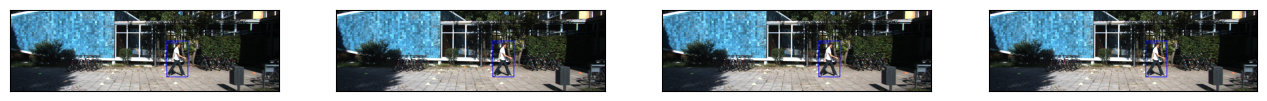

In [11]:
elements = next(iter(data_loader))
print(type(elements))
print(elements)
display_samples_h([next(iter(data_loader)) for _ in range(4)])

# Model

In [12]:
def new_forward_vgg(model, x: torch.Tensor) -> torch.Tensor:
        x = model.features(x)
        # Skipping the flattening, the average pooling and the original classifier
        return x

def new_forward_resnet(model, x: torch.Tensor) -> torch.Tensor:
        x = model.conv1(x)
        x = model.bn1(x)
        x = model.relu(x)
        x = model.maxpool(x)

        x = model.layer1(x)
        x = model.layer2(x)
        x = model.layer3(x)

        return x

In [13]:
def convert_rois(rois: torch.Tensor) -> torch.Tensor:
    # Create a tensor of zeros with shape [64, 1]
    zeros_column = torch.zeros(64, 1, device=DEVICE)

    # Adding a column full of zeros as first column since RoI Pool needs the id of the picture in the batch (works for batch size 1)
    final_rois = torch.cat((zeros_column, rois), dim=1)
    return final_rois

In [14]:
def check_for_nans(module, input, output):
    if torch.isnan(output).any():
        raise ValueError(f"NaN values detected in output of {module}")

def print_grad(module, grad_input, grad_output):
    print(f"Gradient of module {module}:")
    print('input')
    print(grad_input)
    print('output')
    print(grad_output)

def register_hooks(model):
    for layer in model.children():
        layer.register_forward_hook(check_for_nans)
        layer.register_forward_hook(print_grad)


In [15]:
class FastRCNN(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.dropout=0.5

        self.conv1 = nn.Conv2d(1024, 128, kernel_size=1)

        self.roi_pool = RoIPool(output_size=(7, 7), spatial_scale=0.0625)
        #self.conv = self._prepare_vgg16()
        self.conv = self._prepare_resnet50()

        self.fc = nn.Sequential(
            nn.Linear(in_features=128 * 7 * 7, out_features=6272),
            nn.LayerNorm([6272]),
            nn.ReLU(True),
            nn.Dropout(p=self.dropout),
        )

        self.classifier = nn.Linear(in_features=6272, out_features=n_classes + 1)
        self.bbox_regressor = nn.Linear(in_features=6272, out_features=4)
        

        #register_hooks(self)

    def _prepare_vgg16(self, weights: Optional[VGG16_Weights] = None) -> nn.Module:
        vgg16 = models.vgg16(weights)
        #vgg16 = vgg16.to(DEVICE)

        # Replace the existing forward method
        vgg16.forward = lambda x: new_forward_vgg(vgg16, x)

        vgg16.features[-1] = nn.Identity()
        vgg16.avgpool = nn.Identity()
        vgg16.classifier = nn.Identity()

        return vgg16
    
    def _prepare_resnet50(self, weights: Optional[VGG16_Weights] = None) -> nn.Module:
        resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        # Remove the fully connected layer and average pooling layer at the end
        resnet50.forward = lambda x: new_forward_resnet(resnet50, x)
        return resnet50

    def forward(self, x):
        # Model input: tuple of 1. single image tensor 2. BoundingBoxes tensor of region proposal ROIs

        img, rois = x
        
        rois = convert_rois(rois)
        
        fmap = self.conv(img)
        fmap = self.conv1(fmap)


        windows = self.roi_pool(fmap, rois=rois)
        windows = torch.flatten(windows, start_dim=1)
        windows = self.fc(windows)

        pred_classes = self.classifier(windows)
        pred_bboxes = self.bbox_regressor(windows)

        return pred_classes, pred_bboxes

# Class weights

In [16]:
TRAIN_ROI_PROPOSALS = 64
BIG_IOU_THRESHOLD = 0.25

In [17]:
# Calculating class weights
# Calculating weights as inverse ratio of count
# Also since we will add
print(f'Class counts: {class_counts}')
classification_weights = class_counts.copy()
n_objects = sum(list(class_counts.values()))

for key, value in classification_weights.items():
    classification_weights[key] = classification_weights[key] * (16 / n_objects) 
    if value:
        classification_weights[key] = 1 / value

classification_weights['background'] = 1 / (TRAIN_ROI_PROPOSALS - (TRAIN_ROI_PROPOSALS * BIG_IOU_THRESHOLD))

print(classification_weights)

Class counts: {'Car': 8297, 'Van': 881, 'Truck': 343, 'Pedestrian': 1034, 'Person_sitting': 44, 'Cyclist': 374, 'Tram': 140, 'Misc': 251, 'DontCare': 0}
{'Car': 0.0001205254911413764, 'Van': 0.0011350737797956867, 'Truck': 0.0029154518950437317, 'Pedestrian': 0.0009671179883945841, 'Person_sitting': 0.022727272727272728, 'Cyclist': 0.00267379679144385, 'Tram': 0.007142857142857143, 'Misc': 0.00398406374501992, 'DontCare': 0.0, 'background': 0.020833333333333332}


# Generating proposals

In [18]:
def restore_encoding(tensor: torch.Tensor) -> torch.Tensor:
    new_tensor = torch.Tensor().to(DEVICE)
    for element in tensor:
        if element == 0:
          element = element + 1
        new_row = torch.tensor(element-1).unsqueeze(0)
        new_row = new_row.to(DEVICE)
        new_tensor = torch.cat([new_tensor, new_row], dim=0)

    new_tensor = new_tensor.to(dtype=torch.int32, device=DEVICE)

    return new_tensor

In [19]:
def convert_tensor_to_cv2(tensor: Tensor) -> np.array:
    numpy_image = tensor.numpy(force=True) # force=True if on GPU
    # Detaches tensor and returns numpy

    # CHW -> HWC
    cv2_image = np.transpose(numpy_image, (1, 2, 0))

    # Convert color space: RGB -> BGR
    cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_RGB2BGR)

    return cv2_image

def generate_roi_proposals(img: torch.Tensor, loaded_rois = None, idx = None) -> BoundingBoxes:
    # If pre loaded RoI proposals exist, then we load them from there
    if loaded_rois:
        proposal_tensor = loaded_rois[idx].to(DEVICE)
        return proposal_tensor
    
    # Convert image from tensor to opencv format.
    cv2_image = convert_tensor_to_cv2(img)


    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(cv2_image)
    ss.switchToSelectiveSearchFast() #Other option is fast, but less accurate
    rects = ss.process() # rects is a np array containing [x, y, w, h] numpy arrays

    #print(f'Number of generated RoIs is: {len(rects)}')

    boxes = [(float(rect[0]), float(rect[1]), float(rect[0]+rect[2]), float(rect[1]+rect[3])) for rect in rects] # convert to the consistent XYXY format
    boxes = torch.tensor(boxes, device=DEVICE) 

    return boxes

In [20]:
def getIoUProposals(ious: torch.Tensor, roi_proposals: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    max_n_real_proposals = int(TRAIN_ROI_PROPOSALS * BIG_IOU_THRESHOLD)

    # Getting the max IoU for every RoI
    max_ious, gt_indices = ious.max(dim=1)

    # Getting the number of real RoI-s 
    num_gte_real_threshold = (max_ious >= 0.5).sum().item()
    
    # Getting the number of background RoIs
    n_real_proposals = min(max_n_real_proposals, num_gte_real_threshold)
    n_background_proposals = TRAIN_ROI_PROPOSALS - n_real_proposals

    # Sorting the values and getting the indices
    sorted_indices_for_iou_value = torch.argsort(max_ious, descending=True)

    real_indices_for_iou_value = sorted_indices_for_iou_value[:n_real_proposals]
    background_indices_for_iou_value = sorted_indices_for_iou_value[num_gte_real_threshold : num_gte_real_threshold + n_background_proposals]

    real_rois = roi_proposals[real_indices_for_iou_value]
    background_rois = roi_proposals[background_indices_for_iou_value]

    real_gts = gt_indices[real_indices_for_iou_value]

    # Dont need since these will be considered background
    background_gts = gt_indices[background_indices_for_iou_value]

    # Returns the RoIs with more than 0.5 IoU (max 16) --> shape [n_real_proposals, 4]
    # Returns the RoIs woth less then 0.5 IoU (max 64 - ...) --> shape [n_background_proposals, 4]
    # Returns the indices of the ground truth corresponding to the real RoIs (So which one is the corresponding object on the picture)
    return real_rois, background_rois, real_gts, background_gts

In [21]:
def calculate_target_bbox_correction(roi_bboxes: BoundingBoxes, gt_bboxes: BoundingBoxes) -> torch.Tensor:

    assert roi_bboxes.shape[0] == gt_bboxes.shape[0]
    correction_vectors = torch.Tensor().to(DEVICE)

    for i in range(roi_bboxes.shape[0]):
        gx, gy, gx2, gy2 = gt_bboxes[i]
        gw = gx + gx2
        gh = gy + gy2

        px, py, px2, py2 = roi_bboxes[i]
        pw = px + px2
        ph = py + py2

        tx = (gx - px) / pw
        ty = (gy - py) / ph
        tw = torch.log(gw / pw)
        th = torch.log(gh / ph)
        transform_tensor = torch.Tensor((tx, ty, tw, th)).unsqueeze(0)
        transform_tensor = transform_tensor.to(DEVICE)

        correction_vectors = torch.cat([correction_vectors, transform_tensor], dim=0)
        correction_vectors = correction_vectors.to(DEVICE)

    return correction_vectors

In [22]:
def get_target_classes(labels: torch.Tensor, gt_indices: torch.Tensor) -> torch.Tensor:
    gt_target_labels = torch.Tensor().to(device=DEVICE)
    
    for idx in gt_indices:
        # Adding one to so 0 is background
        class_id = labels[idx] + 1

        # Concatenate the existing tensor with the new element
        gt_target_labels = torch.cat((gt_target_labels, torch.tensor(class_id).unsqueeze(0)), dim=0)

    gt_target_labels = gt_target_labels.to(dtype=torch.int32)

    return gt_target_labels

In [23]:
def generate_training_samples(ground_truth: DataSample, saved_rois = None, idx= None) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    # input: DataSample containing image and ground truth labels
    # output: tuple of 1. ROI proposals 2. target classes 3. target bounding box corrections 4. all roi boxes 5. real roi boxes
    #         ROI proposals should be a List[Tensor] where the Tensore's shape is (1,4)
    #         each are tensors of shape (TRAINING_ROI_PROPOSALS, ...)
    img = ground_truth[0]
    boxes = ground_truth[1].get('boxes')
    labels = ground_truth[1].get('labels')

    if not boxes.shape[0]:
        # There are no objects on the picture 
        return None, None, None, None, None
    
    img = img.to(DEVICE)
    boxes = boxes.to(DEVICE)
    labels = labels.to(DEVICE)
  
    roi_proposals = generate_roi_proposals(img, saved_rois, idx)

    # Get the IoU of proposals and ground thruthes
    # The returned shape of tensor is [n_proposals, n_gt]   
    ious = box_iou(roi_proposals, boxes)

    real_roi_proposals, background_roi_proposals, real_gts, background_gts  = getIoUProposals(ious, roi_proposals)

    if real_roi_proposals.nelement() == 0:
       return None, None, None, None, None

    # Concat the roi proposals
    roi_proposals = torch.cat([real_roi_proposals, background_roi_proposals], dim=0)

    # Get the target classes
    real_target_classes = get_target_classes(labels, real_gts)
    background_target_classes = torch.zeros(background_roi_proposals.shape[0], dtype=torch.int32, device=DEVICE)

    target_classes = torch.cat([real_target_classes, background_target_classes], dim=0)

    # Calculate the bounding box corrections. Only for the real bboxes, the others are not calculated in the loss
    if not real_gts.nelement() == 0:
      real_gt_bboxes_for_rois = [boxes[idx] for idx in real_gts]
      real_gt_bboxes_for_rois = torch.stack(real_gt_bboxes_for_rois)
      real_gt_bboxes_for_rois = real_gt_bboxes_for_rois.to(DEVICE)
    else:
       real_gt_bboxes_for_rois = torch.Tensor().to(device=DEVICE)

    if not background_gts.nelement() == 0:
      background_gt_bboxes_for_rois = [boxes[idx] for idx in background_gts]
      background_gt_bboxes_for_rois = torch.stack(background_gt_bboxes_for_rois)
      background_gt_bboxes_for_rois = background_gt_bboxes_for_rois.to(DEVICE)
    else:
       background_gt_bboxes_for_rois = torch.Tensor().to(device=DEVICE)

    real_target_bbox_correction = calculate_target_bbox_correction(real_roi_proposals, real_gt_bboxes_for_rois)
    background_target_bbox_correction = calculate_target_bbox_correction(background_roi_proposals, background_gt_bboxes_for_rois)

    target_bbox_correction = torch.zeros(TRAIN_ROI_PROPOSALS, 4, device=DEVICE)

    if not real_target_classes.nelement() == 0:
      target_bbox_correction[:real_target_classes.shape[0], :] = real_target_bbox_correction
    target_bbox_correction[real_target_classes.shape[0]:, :] = background_target_bbox_correction


    if not real_roi_proposals.shape[0] + background_roi_proposals.shape[0] == TRAIN_ROI_PROPOSALS:
      print('THERE ARE NOT ENOUGH PROPOSALS, which is a big problem...')

    return roi_proposals, target_classes, target_bbox_correction, roi_proposals, real_roi_proposals 

# Testing training

In [24]:
"""
count_none = 0
count_less = 0
count_correct = 0

for idx, sample in enumerate(data_loader):

    img = sample[0]
    boxes = sample[1].get('boxes')
    labels = sample[1].get('labels')

    roi_proposals, target_classes, target_bbox_correction, roi_proposals, real_roi_proposals = generate_training_samples(sample, train_rois, 0)

    if roi_proposals == None:
        count_none += 1
    elif real_roi_proposals.shape[0] < 8:
        count_less += 1
    else:
        count_correct += 1

    print(f'Iteration: {idx+1}', end='\r')


print(f'None: {count_none}')
print(f'Less: {count_less}')
print(f'Correct: {count_correct}')
"""


"\ncount_none = 0\ncount_less = 0\ncount_correct = 0\n\nfor idx, sample in enumerate(data_loader):\n\n    img = sample[0]\n    boxes = sample[1].get('boxes')\n    labels = sample[1].get('labels')\n\n    roi_proposals, target_classes, target_bbox_correction, roi_proposals, real_roi_proposals = generate_training_samples(sample, train_rois, 0)\n\n    if roi_proposals == None:\n        count_none += 1\n    elif real_roi_proposals.shape[0] < 8:\n        count_less += 1\n    else:\n        count_correct += 1\n\n    print(f'Iteration: {idx+1}', end='\r')\n\n\nprint(f'None: {count_none}')\nprint(f'Less: {count_less}')\nprint(f'Correct: {count_correct}')\n"

# Loss calculation

In [25]:
# See 2.1 / Multi task loss

class MultiTaskLoss(nn.Module):

   def __init__(self, classification_weights = None, lmbd : Optional[float] = 1.0) -> None:
      super().__init__()
      self.classification_weights = classification_weights
      self.lmbd = lmbd


   def forward(self, input: tuple[torch.Tensor, torch.Tensor], target: tuple[torch.Tensor, torch.Tensor]):
      input_class, input_bbox = input
      target_class, target_bbox = target

      c = torch.where(target_class < 1, 0.0, 1.0)
      real_all_ratio = (c.sum() / TRAIN_ROI_PROPOSALS)
      c = c.unsqueeze(1)

      target_class_clone = target_class.clone()
      target_class_clone = target_class_clone.type(torch.long)


      if not classification_weights == None:
         classification_weights_clone = torch.tensor(list(classification_weights.values())).to(DEVICE)

         classification_weights_clone[0] = classification_weights_clone[0] * real_all_ratio
         for i in range(1, len(classification_weights_clone)):
            classification_weights_clone[i] = classification_weights_clone[i] * (1 - real_all_ratio)

      cls_loss = nn.functional.cross_entropy(input_class, target_class_clone, weight=classification_weights_clone)
      #print(f'Cross entropy loss: {cls_loss}')

      assert not math.isnan(cls_loss)

      smooth_loss = nn.SmoothL1Loss(reduction='none')

      loc_loss = smooth_loss(input_bbox, target_bbox)
      loc_loss = loc_loss.sum(dim=1).unsqueeze(1)
      loc_loss = c * loc_loss
      loc_loss = loc_loss.sum()

      return cls_loss + self.lmbd * loc_loss

# Model training

In [26]:
def train_model(model: nn.Module,
                train_loader: DataLoader,
                valid_loader: DataLoader,
                batch_size: int,
                loss_fn: nn.Module,
                optimizer: optim.Optimizer,
                scheduler: optim.lr_scheduler.LRScheduler,
                epochs: int,
                patience: int,
                device: torch.device,
                train_rois: Optional[str] = None,
                valid_rois: Optional[str] = None):

    n_train_samples = len(train_loader.dataset)
    n_valid_samples = len(valid_loader.dataset)

    noobj_counter = 0

    best_val_loss = float('inf')
    patience_threshold = patience
    patience_counter = patience_threshold

    model.to(device)

    for epoch in range(epochs):
        # train
        n_train_batches = len(train_loader)
        model = model.train()
        train_loss = 0.0
        for idx, sample in enumerate(train_loader):
            if (not torch.numel(sample[1].get('labels'))):
                noobj_counter += 1
                print(f'[{epoch + 1:>2}/{epochs}]: Sample does not have an object: {noobj_counter}/{idx}', end='\r')
                continue

            if idx >= len(train_rois):
                break
            
            img = sample[0]
            img = img.to(DEVICE)
            
            new_img_shape = (batch_size,) + img.shape
            img = img.expand(new_img_shape)
            #print(f'img device: {img.device}')

            roi, target_class, target_bbox_corr, a, b = generate_training_samples(sample, train_rois, idx)

            if roi is None:
                continue

            X = (img, roi)
            Y = (target_class, target_bbox_corr)

            pred = model(X)

            loss = loss_fn(pred, Y)
            
            # Backpropagation
            loss.backward()

            # Gradient Clipping
            clip_grad_norm_(model.parameters(), max_norm=0.5)

            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item()
            torch.cuda.empty_cache()
            print(f'[{epoch + 1:>2}/{epochs}]: train_loss={loss:>5f}  [{idx:>5d}/{n_train_samples:>5d}]', end='\r')

        train_loss /= n_train_batches

        scheduler.step()


        # validate
        n_valid_batches = len(valid_loader)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for idx, sample in enumerate(valid_loader):
                if (not torch.numel(sample[1].get('labels'))):
                    continue

                if idx >= len(valid_rois):
                    break

                img = sample[0]
                img = img.to(DEVICE)
                
                new_img_shape = (batch_size,) + img.shape
                img = img.expand(new_img_shape)

                roi, target_class, target_bbox_corr, a, b = generate_training_samples(sample, valid_rois, idx)

                if roi is None:
                    continue

                X = (img, roi)
                Y = (target_class, target_bbox_corr)

                pred = model(X)
                loss = loss_fn(pred, Y)

                val_loss += loss.item()
                torch.cuda.empty_cache()
                print(f'[{epoch + 1:>2}/{epochs}]: val_loss={loss:>5f}  [{idx:>5d}/{n_valid_samples:>5d}]', end='\r')

        val_loss /= n_valid_batches
        print(f'[{epoch + 1:>2}/{epochs}]: {train_loss=:5f} {val_loss=:5.5f}')

        patience_counter -= 1

        # Implementing early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = patience_threshold

            # Saving the model with the best validation loss
            torch.save(model.state_dict(), 'best_model.pth')

        if patience_counter == 0:
            print("Early stop to prevent model from overfitting")
            break

    print(f'Validation loss: {best_val_loss}')




In [27]:
train_loader = data_loader
valid_loader = valid_loader

train_rois = torch.load('roi_proposals_list_train.pt')
valid_rois = torch.load('roi_proposals_list_valid.pt')

In [28]:
model = FastRCNN()

batch_size = 1
loss_fn = MultiTaskLoss(classification_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001, eps=1e-10, weight_decay=2e-4, amsgrad=True)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

epochs = 6
patience = 3
device = DEVICE


train_model(model, train_loader, valid_loader, batch_size, loss_fn, optimizer, scheduler, epochs, patience, device, train_rois, valid_rois)

/tmp/ipykernel_560202/1189844371.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_target_labels = torch.cat((gt_target_labels, torch.tensor(class_id).unsqueeze(0)), dim=0)


[ 1/6]: train_loss=1.121968 val_loss=0.74862197
[ 2/6]: train_loss=0.659698 val_loss=0.63482197
[ 3/6]: train_loss=0.560939 val_loss=0.63940197
[ 4/6]: train_loss=0.485586 val_loss=0.66252197
[ 5/6]: train_loss=0.430779 val_loss=0.64664197
Early stop to prevent model from overfitting
Validation loss: 0.63481538926057


In [29]:
print(len(train_rois))
print(len(train_loader))

print(len(valid_rois))
print(len(valid_loader))


5219
5237
1120
1122


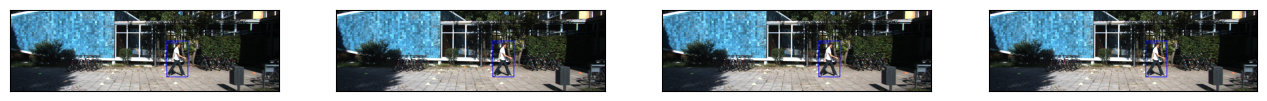

In [30]:
test_sample = None

for idx, element in enumerate(data_loader):
  if idx == 8:
     test_sample = element
     break

display_samples_h([next(iter(data_loader)) for _ in range(4)])

# Test the model

In [31]:
from sklearn.decomposition import TruncatedSVD
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.nn.functional import softmax
from torchvision.ops import nms
from pprint import pprint

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [32]:
def score_image(target_boxes: torch.Tensor,
                target_labels: torch.Tensor,
                pred_boxes: torch.Tensor,
                pred_class: torch.Tensor,
                pred_label: torch.Tensor,
                mAP: MeanAveragePrecision):

    mAP_pred_dict = dict.fromkeys(['boxes', 'scores', 'labels'], None)
    mAP_target_dict = dict.fromkeys(['boxes', 'labels'], None)

    mAP_target_dict['boxes'] = target_boxes.to(dtype=torch.float)
    mAP_target_dict['labels'] = target_labels.to(dtype=torch.int)

    mAP_pred_dict['boxes'] = pred_boxes.to(dtype=torch.float)
    mAP_pred_dict['scores'] = pred_class.to(dtype=torch.float)
    mAP_pred_dict['labels'] = pred_label.to(dtype=torch.int)

    
    mAP.update([mAP_pred_dict], [mAP_target_dict])

In [33]:
def test_model(model: nn.Module,
                test_loader: DataLoader,
                batch_size: int,
                mAP: MeanAveragePrecision,
                device: torch.device,
                test_rois = None):
    
    model.to(device)
    
    # Iterating through the images and generating the predicted bounding boxes
    model.eval()
    with torch.no_grad():
        for idx, sample in enumerate(test_loader):
            if (not torch.numel(sample[1].get('labels'))):
                continue

            if idx >= len(test_rois):
                break
            
            img = sample[0]
            img = img.to(DEVICE)
            
            new_img_shape = (batch_size,) + img.shape
            img = img.expand(new_img_shape)

            roi, target_class, target_bbox_corr, roi_boxes, real_roi_boxes = generate_training_samples(sample, test_rois, idx)

            if roi is None:
                continue

            X = (img, roi)
            Y = (target_class, target_bbox_corr)

            pred = model(X)

            # Important values
            target_boxes = sample[1].get('boxes').to(DEVICE)
            target_labels = sample[1].get('labels').to(DEVICE)
            target_labels += 1

            pred_class, pred_bbox = pred
            
            pred_class = softmax(pred_class, dim=1)
            conf_score, pred_label = torch.max(pred_class, dim=1)
            pred_boxes = roi_boxes 
            pred_real_boxes = real_roi_boxes
            pred_real_labels = pred_label[:pred_real_boxes.shape[0]]
            pred_real_class = pred_class[:pred_real_boxes.shape[0]]

            # Do Non-Maximal suppression
            nms_indices = nms(pred_real_boxes, pred_real_labels, iou_threshold=0.5)

            pred_real_boxes = pred_real_boxes[nms_indices]
            pred_real_labels = pred_real_labels[nms_indices]
            pred_real_class = pred_real_class[nms_indices]
            
            # Lets check what to do with
            score_image(target_boxes, target_labels, pred_real_boxes, pred_real_class, pred_real_labels, mAP)

            
            # Display the test result
            #display_one(img, pred_real_boxes, pred_real_labels)

            torch.cuda.empty_cache()
            print(f'Done with image number {idx+1}', end='\r')


    # Compute the final mAP score
    final_mAP = mAP.compute().item()
    print(f"Final mAP Score: {final_mAP}")

    return

In [34]:
# Truncated SVD
# Example function to find an appropriate rank
def find_rank(W, explained_variance_threshold=0.95):
    svd = TruncatedSVD(n_components=min(W.shape) - 1)
    svd.fit(W)
    cumulative_variance = np.cumsum(svd.explained_variance_ratio_)
    rank = np.searchsorted(cumulative_variance, explained_variance_threshold) + 1
    return rank

# Function to apply Truncated SVD to a single layer
def apply_truncated_svd(layer, explained_variance_threshold=0.95):
    if isinstance(layer, nn.Linear):
        W = layer.weight.data.cpu().numpy()
        bias = layer.bias.data.cpu().numpy() if layer.bias is not None else None
        
        rank = find_rank(W, explained_variance_threshold)
        svd = TruncatedSVD(n_components=rank)
        W_reduced = svd.fit_transform(W)
        components = svd.components_
        
        new_layer1 = nn.Linear(W.shape[1], rank, bias=False)
        new_layer2 = nn.Linear(rank, W.shape[0], bias=layer.bias is not None)
        
        new_layer1.weight.data = torch.tensor(W_reduced, dtype=torch.float32)
        new_layer2.weight.data = torch.tensor(components, dtype=torch.float32)
        
        if layer.bias is not None:
            new_layer2.bias.data = torch.tensor(bias, dtype=torch.float32)
        
        return nn.Sequential(new_layer1, new_layer2)
    else:
        return layer

# Function to apply Truncated SVD to all layers in a model
def apply_svd_to_model(model, explained_variance_threshold=0.95):
    for name, module in model.named_children():
        if isinstance(module, nn.Sequential):
            new_module = nn.Sequential(*[apply_truncated_svd(layer, explained_variance_threshold) for layer in module])
            setattr(model, name, new_module)
        else:
            new_module = apply_truncated_svd(module, explained_variance_threshold)
            setattr(model, name, new_module)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())


In [35]:
model = FastRCNN()
model.load_state_dict(torch.load('best_model.pth'))
apply_svd_to_model(model, 0.95)

In [ ]:
del test

In [36]:
# Calling the test
model = FastRCNN()
save_path = "best_model.pth"
test_rois = torch.load('roi_proposals_list_test.pt')
batch_size = 1
loss_fn = MultiTaskLoss(classification_weights)
mAP = MeanAveragePrecision()

# We have to call it with the best model, which is saved at ./best_model.pth

# We can truncate the model with truncated SVD
test_model(model, test_loader, batch_size, mAP, DEVICE, test_rois)

ModuleNotFoundError: `MAP` metric requires that `pycocotools` or `faster-coco-eval` installed. Please install with `pip install pycocotools` or `pip install faster-coco-eval` or `pip install torchmetrics[detection]`.

In [ ]:
def display_results(idx: int, test_loader):
    if (idx >= len(test_rois)) | (idx < 0):
        print('Inadequate idx: {idx}')
        return
    
    dataset = test_loader.dataset
    sample = dataset[idx]

    img = sample[0]
    img = img.to(DEVICE)
            
    new_img_shape = (batch_size,) + img.shape
    img = img.expand(new_img_shape)

    roi, target_class, target_bbox_corr, roi_boxes, real_roi_boxes = generate_training_samples(sample, test_rois, idx)

    if roi is None:
        print('No region of intrest is generated')
        return

    X = (img, roi)
    Y = (target_class, target_bbox_corr)

    pred = model(X)

    # Important values
    target_boxes = sample[1].get('boxes').to(DEVICE)
    target_labels = sample[1].get('labels').to(DEVICE)
    target_labels += 1

    pred_class, pred_bbox = pred
    
    pred_class = softmax(pred_class, dim=1)
    conf_score, pred_label = torch.max(pred_class, dim=1)
    pred_boxes = roi_boxes
    pred_real_boxes = real_roi_boxes
    pred_real_labels = pred_label[:pred_real_boxes.shape[0]]
    pred_real_class = pred_class[:pred_real_boxes.shape[0]]

    # Do Non-Maximal suppression
    nms_indices = nms(pred_real_boxes, pred_real_labels, iou_threshold=0.5)

    pred_real_boxes = pred_real_boxes[nms_indices]
    pred_real_labels = pred_real_labels[nms_indices]
    pred_real_class = pred_real_class[nms_indices]


    # Display the test result
    display_one(img, pred_real_boxes, pred_real_labels)

    mAP = MeanAveragePrecision()
    score_image(target_boxes, target_labels, pred_boxes, pred_class, pred_label, mAP)
    
    final_mAP = mAP.compute().item()
    pprint(f"Final mAP Score: {final_mAP}")

In [ ]:
for i in range(10):
    display_results(i, test_loader)

In [ ]:
# TODO


# DONE For Loss classification weight is needed
#       For classes it is already calculated
#       But need to multiply that eith 3/4
#       And weight for Don't care should be 1/3
# DONE -  Since Conv can handle bigger images Dont need rescale 224, 224 transformation
#       Do not need!!
#       But check new dimension
# DONE Put the whole thing on GPU
#
# DONE Validation is needed
#       Validation can be done on the whole image

# DONE - LayerNorm normalization --- NOT Batch normalization 



# Trying out ResNet 50/101

# Should I use mAP for all the rois or just the real ones?




# Just at the end, if enough time - Do 2 Batches



### For learning


# Data augmentation??? More than that??

# Setting the parameters for Adam?




### For testing 

# Scale invarinace - Image pyramids???

# mAP calculation for detection

# Make inference faster with Truncated SVD

# Evaluate
#   Non-maximal supression: 
#       For every object we choose the one from the region proposals that has the highest IoU with the corresponding GT
#
#   Precision:
#       From all of our prediction, how many of them are correct
#       (So from all the predicted bounding boxes, how many has IoU with GT over 0.5)
#
#   Recall:
#       From all the grund truth, how many did we predict correctly
#       
#
#   mAP (mean Average Precision):
#       To say if a predicted bounding box is correct or not
#       Correct if IoU >= 0.5
#       Wring if IoU < 0.5
#
#
#       Look at one class first
#       There are predictions for these classes, and these predictions have a probability
#       Sorting the Bounding boxes based on the probability score
#       Precision - Recall diagram
#       We iterate through the sorted bounding boxes and check if they are correct or not
#
#       The area under the precision - recall diagram is the AP (average precision)
#       
#       We do these calculations for every class
#
#       We take the mean of all these classes and get the mean Average Precision (mAP)
#
#       We redo the calculations with other thresholds (What is the threshold IoU to accept a region proposal)
#
#       And then we take the average of all these numbers